In [2]:
import pandas as pd
import os
import re

In [75]:
dir_salmon = os.path.abspath("d0121virome/p02_pipeline")
salmons = [os.path.join(dir_salmon, x) for x in os.listdir(dir_salmon) if x.startswith('salmon_')]

nreads = []
tpms = []
for f in salmons:
    df = pd.read_csv(os.path.join(f, 'quant.sf'), sep='\t')
    fid = os.path.basename(f).replace('salmon_', '')
    df.rename(columns={'Name':'contig_id', 'NumReads':fid}, inplace=True)
    df_nreads = df[['contig_id', fid]].copy()
    df_nreads.set_index('contig_id', inplace=True)
    df_nreads[fid] = df_nreads.apply(lambda x:int(x[fid]), axis=1)

    df_tpm = df[['contig_id', 'TPM']].copy()
    df_tpm.rename(columns={'TPM':fid}, inplace=True)
    df_tpm.set_index('contig_id', inplace=True)
    
    nreads.append(df_nreads)
    tpms.append(df_tpm)

In [76]:
def extract_length(x):
    m = re.search(r'_length_(.*)_cov', x)
    return int(m.group(1))

In [77]:
tbl_nreads = pd.concat(nreads, axis=1, join='outer').reset_index()
# tbl_nreads['length'] = tbl_nreads.apply(lambda x:extract_length(x['contig_id']), axis=1)
tbl_tpm = pd.concat(tpms, axis=1, join='outer').reset_index()

In [84]:
tbl_tpm.to_csv('viral_abundance_tpm.tsv', sep='\t', index=False)
tbl_nreads.to_csv('viral_abundance_nreads.tsv', sep='\t', index=False)

# Taxonomy annotation

In [87]:
os.chdir('d0121virome/p02_pipeline/')

In [231]:
def confidence(x):
    if x['checkv_quality'] == 'Complete':
        quality = 'complete'
    elif x['checkv_quality'] in ['Complete' 'High-quality', 'Medium-quality'] or x['vibrant']==1 or x['category'] in [1,2,3,5,7]:
        quality = 'high'
    else:
        quality = 'low'
    return quality

def prophage(x):
    if x['provirus']=='Yes' or x['virus_type']=='prophage':
        phage_type = 'prophage'
    else:
        phage_type = 'phage'
    return phage_type
        


def modify_category(x):
    if x['checkv_quality'].isin(['Complete' 'High-quality', 'Medium-quality']):
        category = 7
    elif x['category'].isna():
        if x['vibrant'] == 1:
            category = 7        
        elif x['checkv_quality']=='Low-quality':
            category = 8
        else:
            category = 8
    return category


def modify_virus_type():
    pass

In [216]:
classify = pd.read_csv('tmp_virus.tsv', sep='\t')
checkv = pd.read_csv('quality_summary.tsv', sep='\t')
vibrant = pd.read_csv('all.phages_combined.txt', sep='\t', names=['contig_id'], index_col=0)
vc2 = pd.read_csv('genome_by_genome_overview.csv', sep=',', low_memory=False)
cdhit = pd.read_csv('viral_cluster.map', sep='\t')
vlist = pd.read_csv('viral.list', sep='\t', names=['contig_id'])
taxonomy = pd.read_csv('taxonomy.tsv', sep='\t')

In [217]:
checkv_clean = checkv[['contig_id', 'provirus', 'checkv_quality']].copy()
checkv_clean = checkv_clean[checkv_clean.checkv_quality !="Not-determined"]

cdhit.columns = ["vc_cdhit", 'contig_id']
vibrant['vibrant'] = 1

vc2_clean = vc2[['Genome', 'VC']].copy()
vc2_clean.columns = ['contig_id', 'vc_vcontact2']
vc2_clean = vc2_clean[(vc2_clean.contig_id.str.contains('_NODE_')) & (vc2_clean.vc_vcontact2.notna())]

In [227]:
# merge
dfz = vlist.merge(classify, on='contig_id', how='left')
dfz = dfz.merge(checkv_clean, on='contig_id', how='left')
dfz = dfz.merge(vibrant, on='contig_id', how='left')
dfz = dfz.merge(vc2_clean, on='contig_id', how='left')
dfz = dfz.merge(cdhit, on='contig_id', how='left')

dfz['confidence'] = dfz.apply(lambda x:confidence(x), axis=1)
dfz['phage_type'] = dfz.apply(lambda x:prophage(x), axis=1)

In [228]:
tbl = taxonomy.merge(dfz[['contig_id', 'confidence', 'phage_type', 'vc_vcontact2', 'vc_cdhit']], on='contig_id', how='left')

In [230]:
tbl.to_csv('contig_annotation.tsv', sep='\t', index=False)

# Functional

In [233]:
pfam = pd.read_csv('prot_anno_PFAM.tsv', sep='\t')
pvog = pd.read_csv('prot_anno_pVOG.tsv', sep='\t')
vogdb = pd.read_csv('prot_anno_VOGDB.tsv', sep='\t')
kegg = pd.read_csv('prot_anno_KEGG.tsv', sep='\t')
eggnog = pd.read_csv('prot_anno_eggnog.tsv', sep='\t')

In [9]:
def extract_contig_id(x):
    return '_'.join(x.split('_')[:-1])

In [246]:
kegg['contig_id'] = kegg.apply(lambda x:extract_contig_id(x['protid']), axis=1)

In [256]:
tbl_kegg = kegg.merge(tbl_tpm, on='contig_id', how='left')
tbl_kegg = tbl_kegg[tbl_kegg.Y1v.notna()]

In [261]:
tbl_kegg[tbl_kegg.columns.drop('contig_id')].to_csv('kegg_annotation.tsv', sep='\t', index=False)

# Overlapped KEGG

In [3]:
!pwd

/Users/allen/sync/hms/p0062


In [4]:
vctg = pd.read_csv('d0121virome/p02_pipeline/contig_annotation.tsv', sep='\t')

In [5]:
vctg.head()

,contig_id,taxid,Superkingdom,Order,Family,Genus,Species,length,confidence,phage_type,vc_vcontact2,vc_cdhit
0,Y3v_NODE_19648_length_772_cov_15.446304,unknown,no_rank,no_rank,no_rank,no_rank,no_rank,772,low,phage,NaN,Y3v_NODE_19648_length_772_cov_15.446304
1,Y2v_NODE_22743_length_1295_cov_15.194355,unknown,no_rank,no_rank,no_rank,no_rank,no_rank,1295,low,phage,NaN,Y2v_NODE_22743_length_1295_cov_15.194355
2,Y2v_NODE_22726_length_1296_cov_2.376309,unknown,no_rank,no_rank,no_rank,no_rank,no_rank,1296,high,phage,NaN,Y2v_NODE_22726_length_1296_cov_2.376309
3,Y2v_NODE_22727_length_1296_cov_2.371475,unknown,no_rank,no_rank,no_rank,no_rank,no_rank,1296,high,phage,NaN,Y2v_NODE_22727_length_1296_cov_2.371475
4,Y2v_NODE_22728_length_1296_cov_2.302981,unknown,no_rank,no_rank,no_rank,no_rank,no_rank,1296,high,phage,NaN,Y2v_NODE_22728_length_1296_cov_2.302981


In [6]:
vctg[vctg.contig_id=="Y2v_NODE_16_length_53907_cov_23.947820"]

,contig_id,taxid,Superkingdom,Order,Family,Genus,Species,length,confidence,phage_type,vc_vcontact2,vc_cdhit
50968,Y2v_NODE_16_length_53907_cov_23.947820,10662,Viruses,Caudovirales,Myoviridae,no_rank,no_rank,53907,high,phage,NaN,Y2v_NODE_16_length_53907_cov_23.947820


In [7]:
kegg_bac = pd.read_csv("report/16s_ko.tsv", sep='\t')
kegg_bac.drop("description", axis=1, inplace=True)

In [10]:
kegg_mg = pd.read_csv('d0121virome/p02_pipeline/prot_anno_KEGG.tsv', sep='\t')
kegg_mg['contig_id'] = kegg_mg.apply(lambda x:extract_contig_id(x['protid']), axis=1)
kegg_mgnr = kegg_mg[['protid', 'dbid', 'contig_id']].drop_duplicates()
kegg_mgdesc = kegg_mg[['dbid', 'pathid', 'A', 'B', 'C', 'D']].drop_duplicates()

In [11]:
kegg_mg.shape, kegg_mgnr.shape, kegg_mgdesc.shape

((626485, 8), (322422, 3), (13330, 6))

In [19]:
kegg_olp = kegg_mg.merge(kegg_bac, left_on='dbid', right_on='function', how='inner')
kegg_olp_anno = kegg_olp.merge(rst, on="contig_id", how="inner")

In [20]:
kegg_olp_anno.A.value_counts()

09180 Brite Hierarchies                       113
09120 Genetic Information Processing           43
09190 Not Included in Pathway or Brite         25
09140 Cellular Processes                       20
09100 Metabolism                               14
09130 Environmental Information Processing      5
09160 Human Diseases                            2
Name: A, dtype: int64

In [21]:
kegg_olp_anno.B.value_counts()

09182 Protein families: genetic information processing      68
09124 Replication and repair                                39
09183 Protein families: signaling and cellular processes    39
09192 Unclassified: genetic information processing          13
09145 Cellular community - prokaryotes                      11
09143 Cell growth and death                                  8
09191 Unclassified: metabolism                               6
09181 Protein families: metabolism                           6
09104 Nucleotide metabolism                                  5
09132 Signal transduction                                    5
09194 Poorly characterized                                   5
09108 Metabolism of cofactors and vitamins                   3
09121 Transcription                                          2
09161 Cancer: overview                                       2
09101 Carbohydrate metabolism                                2
09123 Folding, sorting and degradation                 

In [22]:
kegg_olp_anno.C.value_counts()

02048 Prokaryotic defense system [BR:ko02048]                             33
03400 DNA repair and recombination proteins [BR:ko03400]                  25
03032 DNA replication proteins [BR:ko03032]                               16
03030 DNA replication                                                     12
99976 Replication and repair                                              12
03440 Homologous recombination                                            10
03021 Transcription machinery [BR:ko03021]                                 8
03036 Chromosome and associated proteins [BR:ko03036]                      8
04112 Cell cycle - Caulobacter                                             8
03000 Transcription factors [BR:ko03000]                                   7
03430 Mismatch repair                                                      7
03420 Nucleotide excision repair                                           6
99980 Enzymes with EC numbers                                              5

In [23]:
kegg_olp_anno[kegg_olp_anno.C == "00920 Sulfur metabolism"]

,protid,dbid,pathid,A,B,C,D,contig_id,function,Y116S,...,Superkingdom,Order,Family,Genus,Species,length,confidence,phage_type,vc_vcontact2,vc_cdhit
0,Y1v_NODE_2_length_73731_cov_23.549650_11,K00390,ko00920,09100 Metabolism,09102 Energy metabolism,00920 Sulfur metabolism,K00390 cysH; phosphoadenosine phosphosulfate ...,Y1v_NODE_2_length_73731_cov_23.549650,K00390,53826.81,...,Viruses,Caudovirales,Siphoviridae,no_rank,no_rank,73731,complete,phage,NaN,Y1v_NODE_2_length_73731_cov_23.549650


In [122]:
vctg[vctg.vc_cdhit=="Y1v_NODE_2_length_73731_cov_23.549650"]

,contig_id,taxid,Superkingdom,Order,Family,Genus,Species,length,confidence,phage_type,vc_vcontact2,vc_cdhit
10178,Y3v_NODE_19192_length_785_cov_2.741096,unknown,no_rank,no_rank,no_rank,no_rank,no_rank,785,low,phage,NaN,Y1v_NODE_2_length_73731_cov_23.549650
10613,Y3v_NODE_14683_length_933_cov_3.424829,unknown,no_rank,no_rank,no_rank,no_rank,no_rank,933,low,phage,NaN,Y1v_NODE_2_length_73731_cov_23.549650
13672,Y3v_NODE_22673_length_703_cov_3.893519,unknown,no_rank,no_rank,no_rank,no_rank,no_rank,703,low,phage,NaN,Y1v_NODE_2_length_73731_cov_23.549650
37527,Y3v_NODE_12585_length_1028_cov_2.085303,unknown,no_rank,no_rank,no_rank,no_rank,no_rank,1028,high,phage,NaN,Y1v_NODE_2_length_73731_cov_23.549650
38054,Y3v_NODE_11843_length_1067_cov_1.595850,unknown,no_rank,no_rank,no_rank,no_rank,no_rank,1067,low,phage,NaN,Y1v_NODE_2_length_73731_cov_23.549650
38357,Y3v_NODE_10941_length_1120_cov_2.309859,unknown,no_rank,no_rank,no_rank,no_rank,no_rank,1120,low,phage,NaN,Y1v_NODE_2_length_73731_cov_23.549650
39258,Y3v_NODE_11101_length_1109_cov_5.459203,unknown,no_rank,no_rank,no_rank,no_rank,no_rank,1109,low,phage,NaN,Y1v_NODE_2_length_73731_cov_23.549650
39604,Y3v_NODE_9903_length_1194_cov_2.606673,unknown,no_rank,no_rank,no_rank,no_rank,no_rank,1194,low,phage,NaN,Y1v_NODE_2_length_73731_cov_23.549650
40532,Y3v_NODE_8625_length_1305_cov_4.124800,unknown,no_rank,no_rank,no_rank,no_rank,no_rank,1305,high,phage,NaN,Y1v_NODE_2_length_73731_cov_23.549650
41231,Y3v_NODE_8466_length_1320_cov_2.866403,unknown,no_rank,no_rank,no_rank,no_rank,no_rank,1320,low,phage,NaN,Y1v_NODE_2_length_73731_cov_23.549650


In [116]:
kegg_olp_anno.D.value_counts().to_dict()

{'K02335  polA; DNA polymerase I [EC:2.7.7.7]': 18,
 'K00558  DNMT1, dcm; DNA (cytosine-5)-methyltransferase 1 [EC:2.1.1.37]': 10,
 'K02338  dnaN; DNA polymerase III subunit beta [EC:2.7.7.7]': 10,
 'K13581  ccrM; modification methylase [EC:2.1.1.72]': 8,
 'K02313  dnaA; chromosomal replication initiator protein': 8,
 'K10843  ERCC3, XPB; DNA excision repair protein ERCC-3 [EC:3.6.4.12]': 8,
 'K07319  yhdJ; adenine-specific DNA-methyltransferase [EC:2.1.1.72]': 7,
 'K00571  E2.1.1.72; site-specific DNA-methyltransferase (adenine-specific) [EC:2.1.1.72]': 7,
 'K02405  fliA; RNA polymerase sigma factor for flagellar operon FliA': 7,
 'K03497  parB, spo0J; ParB family transcriptional regulator, chromosome partitioning protein': 6,
 'K03111  ssb; single-strand DNA-binding protein': 6,
 'K07689  uvrY, gacA, varA; two-component system, NarL family, invasion response regulator UvrY': 5,
 'K03763  polC; DNA polymerase III subunit alpha, Gram-positive type [EC:2.7.7.7]': 5,
 'K02343  dnaX; DNA 

In [14]:
complete = vctg[vctg.confidence=='complete']

In [15]:
complete

,contig_id,taxid,Superkingdom,Order,Family,Genus,Species,length,confidence,phage_type,vc_vcontact2,vc_cdhit
49961,Y2v_NODE_10_length_63124_cov_19.697221,28883,Viruses,Caudovirales,no_rank,no_rank,no_rank,63124,complete,phage,NaN,Y2v_NODE_10_length_63124_cov_19.697221
50697,Y3v_NODE_17_length_46726_cov_14.680765,10699,Viruses,Caudovirales,Siphoviridae,no_rank,no_rank,46726,complete,phage,185_0,Y3v_NODE_17_length_46726_cov_14.680765
51554,Y2v_NODE_28_length_46762_cov_18.090864,10699,Viruses,Caudovirales,Siphoviridae,no_rank,no_rank,46762,complete,phage,NaN,Y2v_NODE_28_length_46762_cov_18.090864
51573,Y2v_NODE_2_length_101971_cov_80.637123,10699,Viruses,Caudovirales,Siphoviridae,no_rank,no_rank,101971,complete,phage,622_1,Y2v_NODE_2_length_101971_cov_80.637123
51678,Y2v_NODE_27_length_47103_cov_127.244580,194699,Viruses,Caudovirales,Podoviridae,Rauchvirus,Bordetella virus BPP1,47103,complete,phage,150_0,Y2v_NODE_27_length_47103_cov_127.244580
52702,Y2v_NODE_26_length_47845_cov_20.694413,10744,Viruses,Caudovirales,Podoviridae,no_rank,no_rank,47845,complete,phage,169_0,Y2v_NODE_26_length_47845_cov_20.694413
56871,Y1v_NODE_2_length_73731_cov_23.549650,10699,Viruses,Caudovirales,Siphoviridae,no_rank,no_rank,73731,complete,phage,NaN,Y1v_NODE_2_length_73731_cov_23.549650


In [16]:
vc2 = [x for x in complete.vc_vcontact2.values if str(x)!='nan']
cdhit = [x for x in complete.vc_cdhit.values if str(x)!='nan']

In [17]:
rst = vctg[(vctg.vc_vcontact2.isin(vc2)) | (vctg.vc_cdhit.isin(cdhit))]

In [18]:
rst

,contig_id,taxid,Superkingdom,Order,Family,Genus,Species,length,confidence,phage_type,vc_vcontact2,vc_cdhit
10178,Y3v_NODE_19192_length_785_cov_2.741096,unknown,no_rank,no_rank,no_rank,no_rank,no_rank,785,low,phage,NaN,Y1v_NODE_2_length_73731_cov_23.549650
10613,Y3v_NODE_14683_length_933_cov_3.424829,unknown,no_rank,no_rank,no_rank,no_rank,no_rank,933,low,phage,NaN,Y1v_NODE_2_length_73731_cov_23.549650
13672,Y3v_NODE_22673_length_703_cov_3.893519,unknown,no_rank,no_rank,no_rank,no_rank,no_rank,703,low,phage,NaN,Y1v_NODE_2_length_73731_cov_23.549650
37527,Y3v_NODE_12585_length_1028_cov_2.085303,unknown,no_rank,no_rank,no_rank,no_rank,no_rank,1028,high,phage,NaN,Y1v_NODE_2_length_73731_cov_23.549650
38054,Y3v_NODE_11843_length_1067_cov_1.595850,unknown,no_rank,no_rank,no_rank,no_rank,no_rank,1067,low,phage,NaN,Y1v_NODE_2_length_73731_cov_23.549650
38357,Y3v_NODE_10941_length_1120_cov_2.309859,unknown,no_rank,no_rank,no_rank,no_rank,no_rank,1120,low,phage,NaN,Y1v_NODE_2_length_73731_cov_23.549650
39258,Y3v_NODE_11101_length_1109_cov_5.459203,unknown,no_rank,no_rank,no_rank,no_rank,no_rank,1109,low,phage,NaN,Y1v_NODE_2_length_73731_cov_23.549650
39604,Y3v_NODE_9903_length_1194_cov_2.606673,unknown,no_rank,no_rank,no_rank,no_rank,no_rank,1194,low,phage,NaN,Y1v_NODE_2_length_73731_cov_23.549650
40532,Y3v_NODE_8625_length_1305_cov_4.124800,unknown,no_rank,no_rank,no_rank,no_rank,no_rank,1305,high,phage,NaN,Y1v_NODE_2_length_73731_cov_23.549650
41231,Y3v_NODE_8466_length_1320_cov_2.866403,unknown,no_rank,no_rank,no_rank,no_rank,no_rank,1320,low,phage,NaN,Y1v_NODE_2_length_73731_cov_23.549650


In [123]:
from Bio import SeqIO

In [124]:
records = list(SeqIO.parse("/Users/allen/Downloads/Y2vChloroalkane.gb", format="genbank"))

In [127]:
rec = records[0]

In [130]:
f = rec.features[3]

In [139]:
print(f)

type: CDS
location: [585:687](-)
qualifiers:
    Key: db_xref, Value: ['RAST2:fig|10699.270.peg.2']
    Key: locus_tag, Value: hello
    Key: note, Value: ['rasttk_feature_creation_tool=/opt/patric-common/ runtime/bin/phanotate version 1.5.0', 'rasttk_feature_annotation_tool=jinlong.ru@patricbrc .org']
    Key: product, Value: ['hypothetical protein']
    Key: transl_table, Value: ['11']
    Key: translation, Value: ['MKLKYPTHQPVGSTRVNIVSPRWTSPTKSKAKR']



In [137]:
f.qualifiers['locus_tag'] = "hello"

In [140]:
with open('/Users/allen/Desktop/aaa.gb', 'w') as fh:
    SeqIO.write(records, fh, "genbank")

/Users/allen/conda3/envs/binfo/lib/python3.6/site-packages/Bio/SeqIO/InsdcIO.py:687: BiopythonWarning: Increasing length of locus line to allow long name. This will result in fields that are not in usual positions.
  BiopythonWarning,


# Most freq protein

In [80]:
import numpy as np

def match_gene(ko_gene, genes):
    matched_genes = []
    for gene in genes:
        if gene in ko_gene:
            matched_genes.append(gene)
    return ';'.join(matched_genes)

In [84]:
with open('/Users/allen/Dropbox/project/oil_virome/gene.list', 'r') as fh:
    genes = fh.read().splitlines()

df = pd.read_csv('vird0121/report/rst_abundance_proteins.tsv', sep='\t', low_memory=False)
mapping_ko = df[['KO', 'AMG', 'KO_name']].drop_duplicates().copy()

In [85]:
df['abundance'] = df[['Y1v', 'Y2v', 'Y3v']].sum(axis=1)
df['abundance_per_bp'] = df.apply(lambda x:x['abundance']/x['Length'], axis=1)
df.sort_values(by=['abundance_per_bp'], ascending=False, inplace=True)

In [86]:
ko = df[df.KO.notna()][['KO', 'abundance_per_bp']].groupby('KO').sum()
ko.sort_values('abundance_per_bp', ascending=False, inplace=True)
ko.reset_index(inplace=True)

In [91]:
tbl = ko.merge(mapping_ko, on='KO', how='left')

In [92]:
tbl['gene'] = tbl.apply(lambda x:x['KO_name'].split(';')[0], axis=1)
tbl['degradation_genes'] = tbl.apply(lambda x: match_gene(x['gene'], genes), axis=1)

In [93]:
tbl.to_excel('/Users/allen/Desktop/abundant_ko.xlsx', index=False)

In [94]:
df[df.KO=='K13668']

,prot_id,Length,contig_id,KO,AMG,KO_name,Pfam,Pfam_name,VOG,VOG_name,Y1v,Y3v,Y2v,abundance,abundance_per_bp
879,Y3v_NODE_95_length_25979_cov_3.973184_35,1242,Y3v_NODE_95_length_25979_cov_3.973184,K13668,AMG,pimB; phosphatidyl-myo-inositol dimannoside sy...,PF00534.20,Glycosyl transferases group 1,VOG01636,REFSEQ hypothetical protein,27,83,1,111,0.089372


# eggnog

In [254]:
%matplotlib inline
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

def filter_gene_in_eggnog(gene_name, file_eggnog):
    egg = pd.read_csv(file_eggnog, sep='\t')
    egg = egg[egg.preferred_name==gene_name].copy()
    if len(egg) > 0:
        egg['ctgid'] = egg.apply(lambda x:'_'.join(x['prot_id'].split('_')[:-1]), axis=1)
        egg['ctglen'] = egg_degrad.apply(lambda x:int(re.search('_length_([0-9].*)_cov', x['prot_id']).group(1)), axis=1)
        egg.sort_values('ctglen', ascending=False, inplace=True)
    return egg


def add_viral_annotation(eggnog, file_viral, non_viral):
    dfviral = pd.read_csv(file_viral, sep='\t', low_memory=False)
    dfviral.rename(columns={'contig_id':'ctgid'}, inplace=True)
    if non_viral:
        merge_how = 'left'
    else:
        merge_how = 'inner'
    df = eggnog.merge(dfviral, on='ctgid', how=merge_how)
    return df


def main(gene_name, file_eggnog, file_viral, non_viral=True):
    egg = filter_gene_in_eggnog(gene_name, file_eggnog)
    if len(egg)>0:
        df = add_viral_annotation(egg, file_viral, non_viral)
    else:
        df = egg
    return df

In [296]:
file_viral = '/Users/allen/sync/hms/p0062/vird0121/report/rst_abundance_viruses.tsv'
file_eggnog = '/Users/allen/sync/hms/p0062/vird0121/report/anno_eggnog.tsv'
# file_eggnog = '/Users/allen/sync/hms/p0062/vird0121/kraken2_imgvr_bin/anno_eggnog.tsv'
df = main('pimB', file_eggnog, file_viral, non_viral=True)

In [297]:
tbls = []
for gene in genes:
    df = main(gene, file_eggnog, file_viral, non_viral=True)
    if len(df)>0:
        tbls.append(df)

In [298]:
rst = pd.concat(tbls, axis=0)
rst.sort_values('ctglen', ascending=False, inplace=True)

In [299]:
rst.preferred_name.nunique()

46

In [300]:
rst_viral = rst[rst.viral_confidence.notna()]
rst_nonviral = rst[rst.viral_confidence.isna()]

In [301]:
rst_viral.shape, rst_nonviral.shape

((20, 41), (210, 41))

In [302]:
rst_viral.preferred_name.nunique(), rst_nonviral.preferred_name.nunique()

(10, 46)

In [303]:
rst_viral.ctgid.nunique(), rst_nonviral.ctgid.nunique()

(20, 199)

In [322]:
rst_viral.iloc[:,[11,25]+[x for x in range(20,40)]]

,preferred_name,ctglen,kegg_tc,cazy,bigg_reactions,PFAMs,ctgid,ctglen,viral_confidence,provirus_VIBRANT,...,Superkingdom,Phylum,Class,Order,Family,Genus,Species,length,Y1v,Y3v
0,pdhA,7146,-,-,-,"DXP_synthase_N,E1_dh,TPP_enzyme_C,Transket_pyr...",Y1v_NODE_309_length_7146_cov_3.120335,7146,Low-quality,unknown,...,no_rank,no_rank,no_rank,no_rank,no_rank,no_rank,no_rank,7146.0,671.0,92.0
0,adhE,3305,-,-,iSB619.SA_RS00885,"Aldedh,Fe-ADH,Fe-ADH_2",Y3v_NODE_1645_length_3305_cov_2.289145,3305,Not-determined,unknown,...,no_rank,no_rank,no_rank,no_rank,no_rank,no_rank,no_rank,3305.0,4.0,225.0
1,pdhA,2142,-,-,-,"DXP_synthase_N,E1_dh,TPP_enzyme_C,Transket_pyr...",Y2v_NODE_9696_length_2142_cov_11.279980,2142,Low-quality,unknown,...,Viruses,Uroviricota,Caudoviricetes,Caudovirales,Myoviridae,no_rank,no_rank,2142.0,0.0,0.0
0,sucD,1881,-,-,iE2348C_1286.E2348C_0608,"CoA_binding,CoA_binding_2,Ligase_CoA,Succ_CoA_lig",Y1v_NODE_2583_length_1881_cov_1.354658,1881,Not-determined,unknown,...,no_rank,no_rank,no_rank,no_rank,no_rank,no_rank,no_rank,1881.0,86.0,3.0
2,pdhA,1580,-,-,-,"DXP_synthase_N,E1_dh,TPP_enzyme_C,Transket_pyr...",Y1v_NODE_3419_length_1580_cov_2.343687,1580,Low-quality,No,...,no_rank,no_rank,no_rank,no_rank,no_rank,no_rank,no_rank,1580.0,217.0,6.0
4,pdhA,1165,-,-,-,"DXP_synthase_N,E1_dh,TPP_enzyme_C,Transket_pyr...",Y2v_NODE_26828_length_1165_cov_9.522514,1165,Low-quality,unknown,...,Viruses,Uroviricota,Caudoviricetes,Caudovirales,Myoviridae,no_rank,no_rank,1165.0,0.0,0.0
3,bcrA,1159,"3.A.1,3.A.1.131.1",-,-,"AAA_21,ABC_tran",Y3v_NODE_9094_length_1159_cov_1.221698,1159,Not-determined,unknown,...,no_rank,no_rank,no_rank,no_rank,no_rank,no_rank,no_rank,1159.0,0.0,43.0
0,acnB,768,-,-,-,"Aconitase,Aconitase_2_N,Aconitase_B_N",Y1v_NODE_11418_length_768_cov_1.517190,768,Not-determined,unknown,...,no_rank,no_rank,no_rank,no_rank,no_rank,no_rank,no_rank,768.0,34.0,2.0
1,acnB,725,-,-,-,"Aconitase,Aconitase_2_N,Aconitase_B_N",Y1v_NODE_12599_length_725_cov_1.135783,725,Not-determined,unknown,...,no_rank,no_rank,no_rank,no_rank,no_rank,no_rank,no_rank,725.0,25.0,2.0
0,fumC,665,-,-,-,"FumaraseC_C,Lyase_1",Y1v_NODE_14578_length_665_cov_1.842756,665,Not-determined,unknown,...,no_rank,no_rank,no_rank,no_rank,no_rank,no_rank,no_rank,665.0,30.0,0.0


Text(0.5, 0, 'Length (bp)')

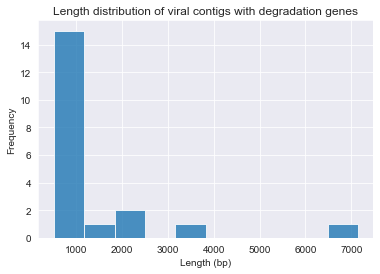

In [269]:
rst_viral[['ctgid', 'ctglen']].drop_duplicates().ctglen.plot.hist(alpha=0.8, title='Length distribution of viral contigs with degradation genes')
plt.xlabel('Length (bp)')

Text(0.5, 0, 'Length (bp)')

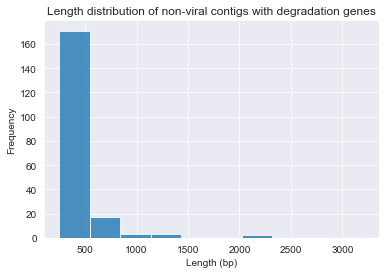

In [270]:
rst_nonviral[['ctgid', 'ctglen']].drop_duplicates().ctglen.plot.hist(alpha=0.8, title='Length distribution of non-viral contigs with degradation genes')
plt.xlabel('Length (bp)')

,prot_id,seed,seed_eval,seed_score,eggnog_ogs,narr_og_name,narr_og_cat,narr_og_desc,best_og_name,best_og_cat,...,Phylum,Class,Order,Family,Genus,Species,length,Y1v,Y3v,Y2v
0,Y3v_NODE_3060_length_2286_cov_1.621856_3,1035187.HMPREF9959_0553,4.000000e-211,589.7,"COG0438@1|root,COG0438@2|Bacteria,1TPTA@1239|F...",2TNK9@28037|Streptococcus mitis,M,Glycosyl transferase 4-like,4HA41@91061|Bacilli,M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Y3v_NODE_16941_length_787_cov_1.220930_1,1035187.HMPREF9959_0553,1.800000e-76,240.0,"COG0438@1|root,COG0438@2|Bacteria,1TPTA@1239|F...",2TNK9@28037|Streptococcus mitis,M,Glycosyl transferase 4-like,4HA41@91061|Bacilli,M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [278]:
with open('/Users/allen/degrad_genes_ctg.list', 'w') as fh:
    fh.write('\n'.join(rst.ctgid.unique()))

In [285]:
rst_viral.preferred_name.value_counts()

pdhA    5
acnB    3
sucA    3
adhE    2
sucB    2
aceE    1
phaA    1
fumC    1
sucD    1
bcrA    1
Name: preferred_name, dtype: int64

In [284]:
rst_viral.iloc[:, 10:]

,best_og_desc,preferred_name,gos,ec,kegg_ko,kegg_pathway,kegg_module,kegg_reaction,kegg_rclas,brite,...,Phylum,Class,Order,Family,Genus,Species,length,Y1v,Y3v,Y2v
0,"oxidoreductase activity, acting on the aldehyd...",pdhA,-,"1.2.4.1,1.2.4.4","ko:K00161,ko:K11381","ko00010,ko00020,ko00280,ko00620,ko00640,ko0110...","M00036,M00307","R00014,R00209,R01699,R03270,R07599,R07600,R076...","RC00004,RC00027,RC00627,RC02742,RC02743,RC0274...","br01601,ko00000,ko00001,ko00002,ko01000",...,no_rank,no_rank,no_rank,no_rank,no_rank,no_rank,7146.0,671.0,92.0,0.0
0,belongs to the iron- containing alcohol dehydr...,adhE,-,"1.1.1.1,1.2.1.10",ko:K04072,"ko00010,ko00071,ko00350,ko00620,ko00625,ko0062...",-,"R00228,R00623,R00754,R01172,R04880,R05233,R052...","RC00004,RC00050,RC00088,RC00099,RC00116,RC0018...","ko00000,ko00001,ko01000",...,no_rank,no_rank,no_rank,no_rank,no_rank,no_rank,3305.0,4.0,225.0,0.0
1,"oxidoreductase activity, acting on the aldehyd...",pdhA,-,"1.2.4.1,1.2.4.4","ko:K00161,ko:K11381","ko00010,ko00020,ko00280,ko00620,ko00640,ko0110...","M00036,M00307","R00014,R00209,R01699,R03270,R07599,R07600,R076...","RC00004,RC00027,RC00627,RC02742,RC02743,RC0274...","br01601,ko00000,ko00001,ko00002,ko01000",...,Uroviricota,Caudoviricetes,Caudovirales,Myoviridae,no_rank,no_rank,2142.0,0.0,0.0,931.0
0,Succinyl-CoA synthetase functions in the citri...,sucD,"GO:0005575,GO:0005622,GO:0005623,GO:0005737,GO...",6.2.1.5,ko:K01902,"ko00020,ko00640,ko00660,ko00720,ko01100,ko0111...","M00009,M00011,M00173,M00374,M00620","R00405,R02404","RC00004,RC00014","ko00000,ko00001,ko00002,ko01000",...,no_rank,no_rank,no_rank,no_rank,no_rank,no_rank,1881.0,86.0,3.0,0.0
2,"oxidoreductase activity, acting on the aldehyd...",pdhA,-,"1.2.4.1,1.2.4.4","ko:K00161,ko:K11381","ko00010,ko00020,ko00280,ko00620,ko00640,ko0110...","M00036,M00307","R00014,R00209,R01699,R03270,R07599,R07600,R076...","RC00004,RC00027,RC00627,RC02742,RC02743,RC0274...","br01601,ko00000,ko00001,ko00002,ko01000",...,no_rank,no_rank,no_rank,no_rank,no_rank,no_rank,1580.0,217.0,6.0,0.0
4,"oxidoreductase activity, acting on the aldehyd...",pdhA,-,"1.2.4.1,1.2.4.4","ko:K00161,ko:K11381","ko00010,ko00020,ko00280,ko00620,ko00640,ko0110...","M00036,M00307","R00014,R00209,R01699,R03270,R07599,R07600,R076...","RC00004,RC00027,RC00627,RC02742,RC02743,RC0274...","br01601,ko00000,ko00001,ko00002,ko01000",...,Uroviricota,Caudoviricetes,Caudovirales,Myoviridae,no_rank,no_rank,1165.0,0.0,0.0,323.0
3,abc transporter atp-binding protein,bcrA,-,-,"ko:K01990,ko:K19309","ko02010,map02010","M00254,M00747",-,-,"ko00000,ko00001,ko00002,ko02000",...,no_rank,no_rank,no_rank,no_rank,no_rank,no_rank,1159.0,0.0,43.0,0.0
0,Belongs to the aconitase IPM isomerase family,acnB,-,"4.2.1.3,4.2.1.99",ko:K01682,"ko00020,ko00630,ko00640,ko00720,ko01100,ko0111...","M00009,M00010,M00012,M00173","R01324,R01325,R01900,R04425","RC00497,RC00498,RC00618,RC01153","br01601,ko00000,ko00001,ko00002,ko01000",...,no_rank,no_rank,no_rank,no_rank,no_rank,no_rank,768.0,34.0,2.0,0.0
1,Belongs to the aconitase IPM isomerase family,acnB,-,"4.2.1.3,4.2.1.99",ko:K01682,"ko00020,ko00630,ko00640,ko00720,ko01100,ko0111...","M00009,M00010,M00012,M00173","R01324,R01325,R01900,R04425","RC00497,RC00498,RC00618,RC01153","br01601,ko00000,ko00001,ko00002,ko01000",...,no_rank,no_rank,no_rank,no_rank,no_rank,no_rank,725.0,25.0,2.0,0.0
0,Involved in the TCA cycle. Catalyzes the stere...,fumC,-,4.2.1.2,ko:K01679,"ko00020,ko00620,ko00720,ko01100,ko01110,ko0112...","M00009,M00011,M00173,M00376",R01082,RC00443,"ko00000,ko00001,ko00002,ko01000",...,no_rank,no_rank,no_rank,no_rank,no_rank,no_rank,665.0,30.0,0.0,0.0
